In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV,
    learning_curve,
    validation_curve
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Load and EDA

In [3]:
data = pd.read_csv("winequalityN.csv")
print("First five rows:\n", data.head(), "\n")
print("Summary statistics:\n", data.describe(), "\n")
print("Missing values per column:\n", data.isnull().sum(), "\n")
print("Class distribution (quality):\n", data['quality'].value_counts(), "\n")

First five rows:
    id   type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0   1  white            7.0              0.27         0.36            20.7   
1   2  white            6.3              0.30         0.34             1.6   
2   3  white            8.1              0.28         0.40             6.9   
3   4  white            7.2              0.23         0.32             8.5   
4   5  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1 

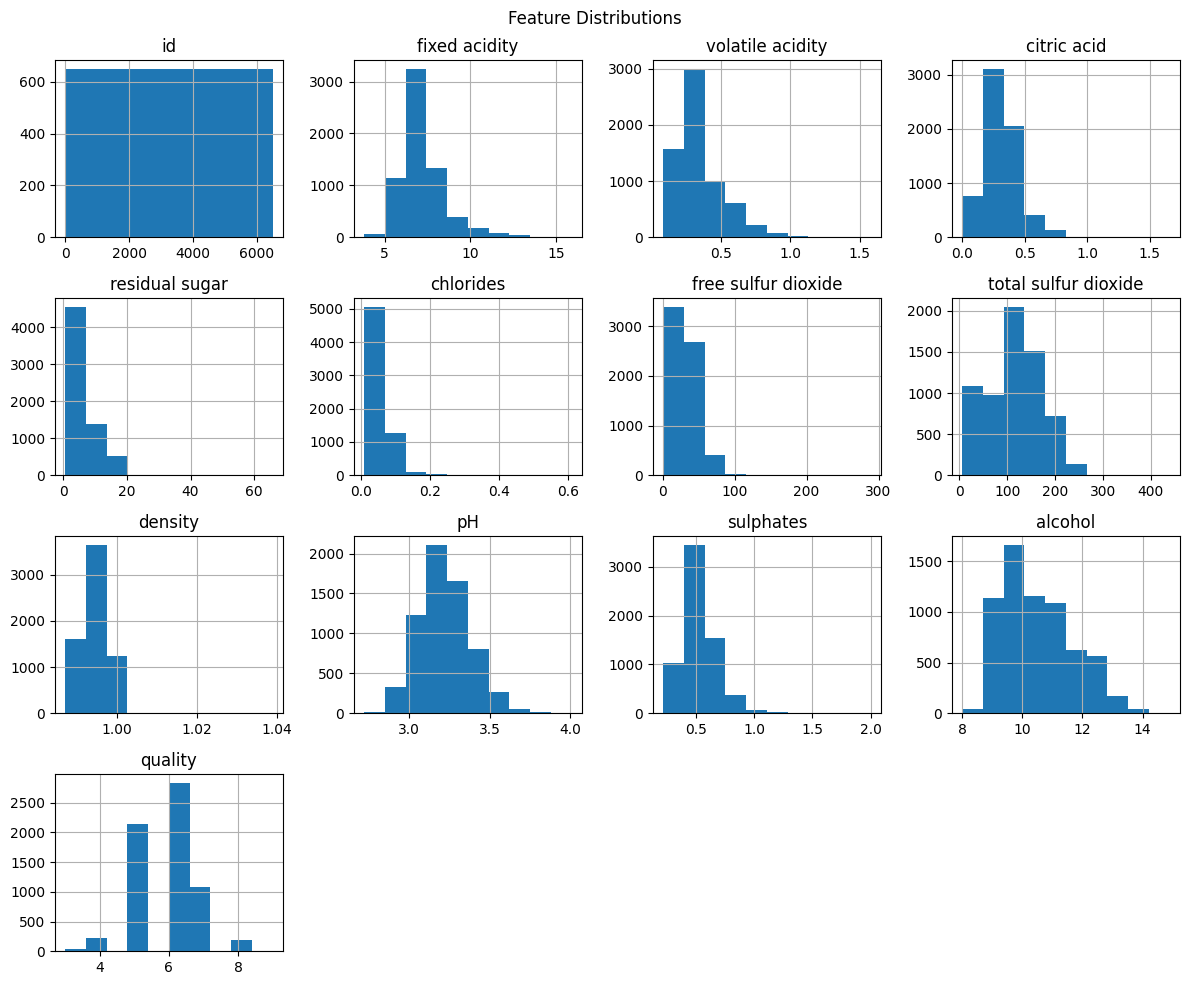

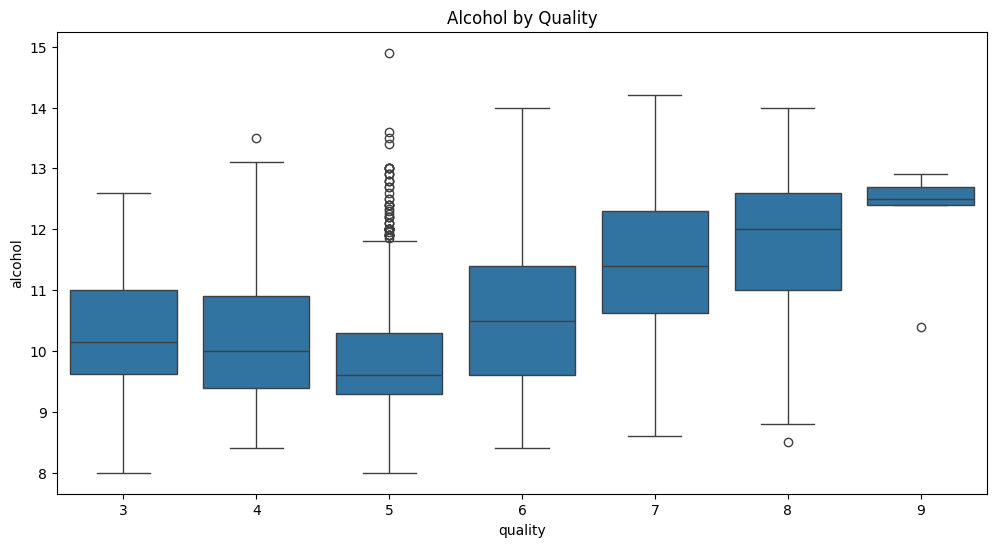

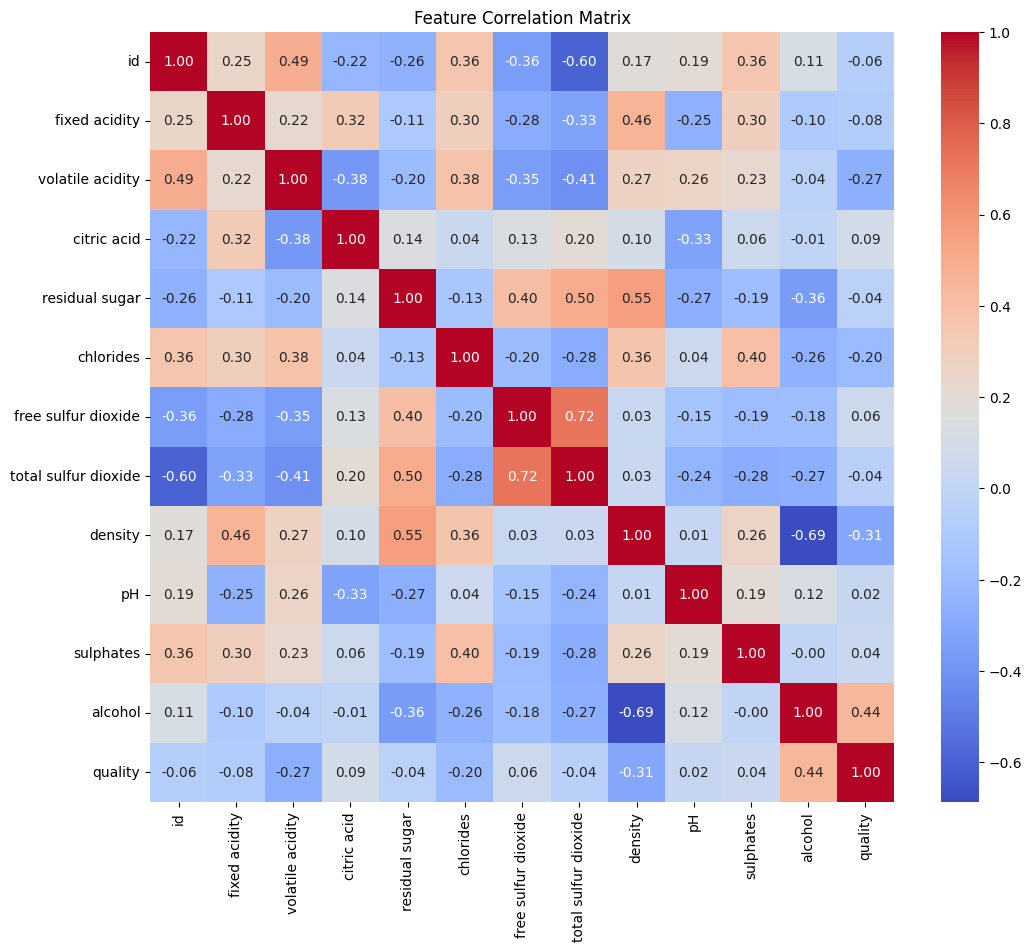

In [4]:

data.hist(figsize=(12,10))
plt.suptitle("Feature Distributions")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12,6))
sns.boxplot(data=data, x='quality', y='alcohol')
plt.title("Alcohol by Quality")
plt.show()


plt.figure(figsize=(12,10))
num_df = data.select_dtypes(include=[np.number])
sns.heatmap(num_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

## Preprocessing

In [5]:
df = data.copy()
df = pd.get_dummies(df, columns=['type'], prefix='type')

# Impute missing values
imputer = SimpleImputer()
df[df.columns] = imputer.fit_transform(df)

# Scale features (exclude target)
scaler = MinMaxScaler()
features = df.columns.drop('quality')
df[features] = scaler.fit_transform(df[features])

X = df.drop('quality', axis=1)
y = df['quality']

## train / test

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Base metrics

In [7]:
def evaluate(model, X, y, name):
    preds = model.predict(X)
    return {
        'model': name,
        'RMSE': np.sqrt(mean_squared_error(y, preds)),
        'MAE': mean_absolute_error(y, preds),
        'R2': r2_score(y, preds)
    }

results = []
dummy = DummyRegressor(strategy='mean').fit(X_train, y_train)
results.append(evaluate(dummy, X_val, y_val, 'Dummy'))

## RandomForest

In [8]:
rf = RandomForestRegressor(random_state=42)

## RandomizedSearchCV

In [10]:

# <… earlier imports and preprocessing …>

rf_rand_params = {
    'n_estimators': [100, 300, 500, 800, 1200],
    'max_depth':    [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}


rf_rand = RandomizedSearchCV(
    rf,
    param_distributions=rf_rand_params,
    n_iter=40,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_rand.fit(X_train, y_train)
best_rf = rf_rand.best_estimator_

print("Best params (randomized):", rf_rand.best_params_)
print("Validation RMSE:", 
np.sqrt(mean_squared_error(y_val, best_rf.predict(X_val))))


Fitting 5 folds for each of 40 candidates, totalling 200 fits


Best params (randomized): {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Validation RMSE: 0.5515417300621958


## GridSearchCV (refined around best parameters)

In [15]:

# assume best_rf_rand is your best estimator from RandomizedSearchCV
best_depth = best_rf.max_depth
if best_depth is None:
    depth_grid = [None, 10, 20]                  # fallback depths
else:
    # ensure we don’t go below 1
    depth_grid = sorted({None, 
                         best_depth, 
                         max(best_depth - 5, 1), 
                         best_depth + 5})

best_split = best_rf.min_samples_split
split_grid = sorted({best_split, best_split + 2})

best_leaf = best_rf.min_samples_leaf
leaf_grid = sorted({best_leaf, best_leaf + 1})

rf_grid_params = {
    'n_estimators': [
        max(best_rf.n_estimators - 200, 1),
        best_rf.n_estimators,
        best_rf.n_estimators + 200
    ],
    'max_depth': depth_grid,
    'min_samples_split': split_grid,
    'min_samples_leaf': leaf_grid,
    'max_features': [best_rf.max_features]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=rf_grid_params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
print("Best grid params:", rf_grid.best_params_)
results.append(evaluate(best_rf, X_val, y_val, 'RF_Grid'))


Fitting 5 folds for each of 36 candidates, totalling 180 fits


Best grid params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700}


## XGBoosting Search

In [16]:


# 1) Define base sklearn‐wrapper model
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    verbosity=0,
    eval_metric='rmse'
)

# 2) RandomizedSearchCV (no early stopping here)
xgb_rand_params = {
    'n_estimators':    [100, 300, 500, 800],
    'max_depth':       [3, 5, 7, 9],
    'learning_rate':   [0.01, 0.05, 0.1, 0.2],
    'subsample':       [0.6, 0.8, 1.0],
    'colsample_bytree':[0.6, 0.8, 1.0]
}
xgb_rand = RandomizedSearchCV(
    xgb_base,
    param_distributions=xgb_rand_params,
    n_iter=30,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)
xgb_rand.fit(X_train, y_train)

best_xgb_rand = xgb_rand.best_estimator_
results.append(evaluate(best_xgb_rand, X_val, y_val, 'XGB_Randomized'))

# 3) Retrain with true early stopping via the xgb.train API
#    (wrapper.fit doesn’t accept callbacks in older XGBoost versions)

# Prepare DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)

# Extract best‐found params and set up for train()
params = best_xgb_rand.get_xgb_params()
params.update({
    'objective':   'reg:squarederror',
    'eval_metric': 'rmse'
})
num_round = best_xgb_rand.get_params()['n_estimators']

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_round,
    evals=[(dval, 'validation')],
    early_stopping_rounds=30,
    verbose_eval=False
)

# Evaluate the trained Booster
preds = bst.predict(dval)
rmse  = np.sqrt(mean_squared_error(y_val, preds))
mae   = mean_absolute_error(y_val, preds)
r2    = r2_score(y_val, preds)
results.append({
    'model': 'XGB_Train_EarlyStop',
    'RMSE':  rmse,
    'MAE':   mae,
    'R2':    r2
})

# 4) Local GridSearchCV around the randomized‐search best params
best = best_xgb_rand.get_params()
xgb_grid_params = {
    'n_estimators':    [max(best['n_estimators']-100, 1), best['n_estimators'], best['n_estimators']+100],
    'max_depth':       [best['max_depth'], best['max_depth']+2],
    'learning_rate':   [best['learning_rate'], best['learning_rate']/2],
    'subsample':       [best['subsample']],
    'colsample_bytree':[best['colsample_bytree']]
}
xgb_grid = GridSearchCV(
    XGBRegressor(
      objective='reg:squarederror',
      random_state=42,
      verbosity=0,
      eval_metric='rmse'
    ),
    param_grid=xgb_grid_params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_
results.append(evaluate(best_xgb, X_val, y_val, 'XGB_Grid'))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 12 candidates, totalling 60 fits


## Results Table

In [17]:
df_results = pd.DataFrame(results).set_index('model')
print("\nModel comparison:\n", df_results, "\n")


Model comparison:
                          RMSE       MAE        R2
model                                            
Dummy                0.845463  0.668714 -0.000013
RF_Grid              0.552421  0.400958  0.573071
XGB_Randomized       0.541017  0.367672  0.590515
XGB_Train_EarlyStop  0.541406  0.370611  0.589926
XGB_Grid             0.540829  0.364530  0.590799 



## Learning Curves

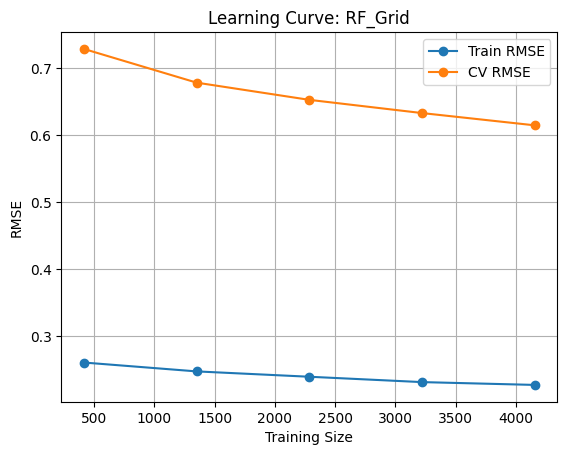

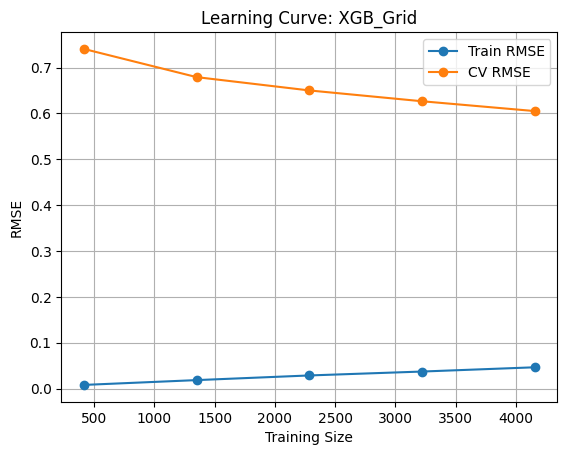

In [18]:
def plot_learning(est, name):
    train_sizes, train_scores, val_scores = learning_curve(
        est, X_train, y_train,
        cv=5, scoring='neg_root_mean_squared_error',
        train_sizes=np.linspace(0.1,1.0,5), n_jobs=-1
    )
    train_rmse = -train_scores.mean(axis=1)
    val_rmse   = -val_scores.mean(axis=1)

    plt.figure()
    plt.plot(train_sizes, train_rmse, 'o-', label='Train RMSE')
    plt.plot(train_sizes, val_rmse, 'o-', label='CV RMSE')
    plt.title(f"Learning Curve: {name}")
    plt.xlabel("Training Size")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid()
    plt.show()

for mdl, name in [(best_rf, 'RF_Grid'), (best_xgb, 'XGB_Grid')]:
    plot_learning(mdl, name)

## Validation Curve

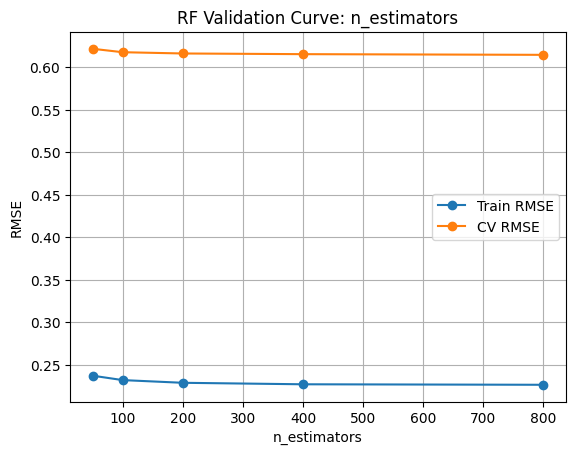

In [19]:
param_range = [50, 100, 200, 400, 800]
train_scores, val_scores = validation_curve(
    best_rf, X_train, y_train,
    param_name='n_estimators', param_range=param_range,
    cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1
)
plt.figure()
plt.plot(param_range, -train_scores.mean(axis=1), 'o-', label='Train RMSE')
plt.plot(param_range, -val_scores.mean(axis=1), 'o-', label='CV RMSE')
plt.title('RF Validation Curve: n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

## Feature Importance

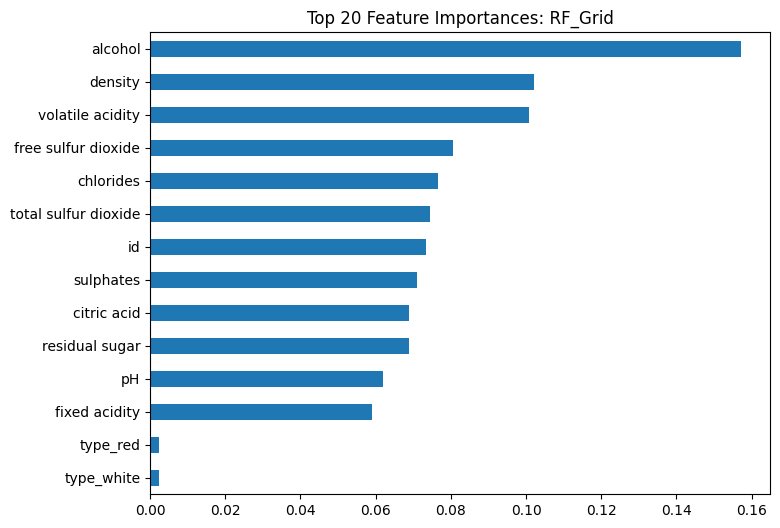

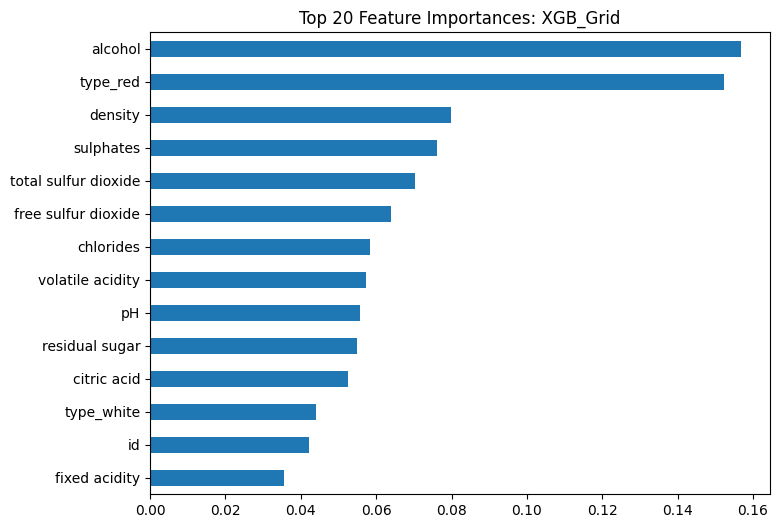

In [20]:
def plot_importances(mdl, name):
    imp = pd.Series(mdl.feature_importances_, index=X_train.columns)
    imp = imp.sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    imp.plot(kind='barh')
    plt.title(f"Top 20 Feature Importances: {name}")
    plt.gca().invert_yaxis()
    plt.show()

plot_importances(best_rf, 'RF_Grid')
plot_importances(best_xgb, 'XGB_Grid')

## Residual Plots

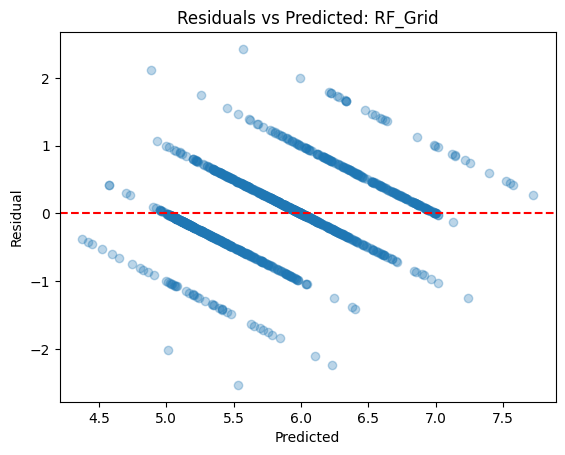

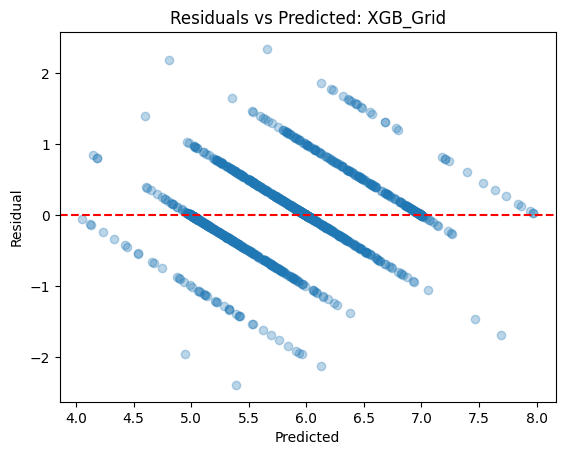

In [21]:
def plot_residuals(mdl, X, y, name):
    preds = mdl.predict(X)
    res   = y - preds
    plt.figure()
    plt.scatter(preds, res, alpha=0.3)
    plt.axhline(0, linestyle='--', color='red')
    plt.title(f"Residuals vs Predicted: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    plt.show()

plot_residuals(best_rf, X_val, y_val, 'RF_Grid')
plot_residuals(best_xgb, X_val, y_val, 'XGB_Grid')